In [ ]:
import time
import numpy as np
from pathlib import Path

from qspectro2d.core.bath_system.bath_class import BathSystem
from qspectro2d.config import DATA_DIR
from qspectro2d.spectroscopy.calculations import (
    parallel_compute_1d_E_with_inhomogenity,
    check_the_solver,
    complex_polarization,
    compute_1d_polarization,
    extract_ift_signal_component,

)

from qspectro2d.visualization import (
    plot_example_evo,
    plot_example_polarization,
    plot_2d_el_field,
)
from qspectro2d.spectroscopy import compute_2d_fft_wavenumber

from qspectro2d.utils import (
    save_data_file,
    save_info_file,
    generate_unique_data_filename,
    get_max_workers,
    print_simulation_summary,
)
from qspectro2d.core.simulation_class import (
    AtomicSystem,
    LaserPulseSequence,
    SimulationConfig,
    SimulationModuleOQS,
)

N_ATOMS = 1
DEFAULT_ODE_SOLVER = "Paper_eqs"
DEFAULT_RWA_SL = True

DEFAULT_BATH_TYPE = "paper"
DEFAULT_BATH_TEMP = 1e-5
DEFAULT_BATH_CUTOFF = 1e2
DEFAULT_BATH_GAMMA_0 = 1 / 300.0
DEFAULT_BATH_GAMMA_PHI = 1 / 100.0
DEFAULT_N_FREQS = 1
DEFAULT_PHASES = 4  # Number of phase cycles for the simulation
DEFAULT_DELTA_CM = 0.0  # Inhomogeneous broadening [cm⁻¹]
DEFAULT_IFT_COMPONENT = (
    1,
    -1,
    1,  # does not matter cause DETECTION_PHASE = 0
)  #  (0, 0, 0) == normal average || (-1, 1, 0) == photon echo signal
DEFAULT_RELATIVE_E0S = [1.0, 1.0, 0.1]  # relative amplitudes for each pulse

def create_simulation_module_from_configs(
    atom_config: dict,
    laser_config: dict,
    bath_config: dict,
    simulation_config: dict,
) -> SimulationModuleOQS:
    """
    Create a simulation module from the provided configuration dictionaries.

    Parameters:
        atom_config (dict): Atomic system configuration.
        laser_config (dict): Laser pulse sequence configuration.
        bath_config (dict): Bath parameters configuration.
        simulation_config (dict): Simulation parameters configuration.

    Returns:
        SimulationModuleOQS: Configured simulation class instance.
    """
    system = AtomicSystem.from_dict(atom_config)
    laser = LaserPulseSequence.from_delays(**laser_config)
    bath = BathSystem.from_dict(bath_config)

    return SimulationModuleOQS(
        simulation_config=SimulationConfig(**simulation_config),
        system=system,
        laser=laser,
        bath=bath,
    )


def run_single_t_coh_with_sim(
    sim_oqs: SimulationModuleOQS,
    t_coh: float,
    save_info: bool = False,
    time_cut: float = -np.inf,
) -> Path:
    """
    Run a single 1D simulation for a specific coherence time using existing SimulationModuleOQS.

    Parameters:
        sim_oqs (SimulationModuleOQS): Pre-configured simulation instance
        t_coh (float): Coherence time between 2 pump pulses [fs]
        save_info (bool): Whether to save simulation info
        time_cut (float): Time cutoff for solver validation

    Returns:
        Path: Relative path to the saved data directory
    """
    print(f"\n=== Starting t_coh = {t_coh:.2f} fs ===")

    # Update t_coh in the simulation config
    sim_oqs.simulation_config.t_coh = t_coh
    t_wait = sim_oqs.simulation_config.t_wait
    sim_oqs.laser.update_delays = [0.0, t_coh, t_wait]

    start_time = time.time()

    # Run the simulation
    print("Computing 1D polarization with parallel processing...")
    try:
        data = parallel_compute_1d_E_with_inhomogenity(
            sim_oqs=sim_oqs,
            time_cut=time_cut,
        )
        print("✅ Parallel computation completed successfully!")
    except Exception as e:
        print(f"❌ ERROR: Simulation failed: {e}")
        raise

    # Save data
    simulation_config_dict = sim_oqs.simulation_config.to_dict()
    abs_path = Path(
        generate_unique_data_filename(sim_oqs.system, simulation_config_dict)
    )
    data_path = Path(f"{abs_path}_data.npz")
    print(f"\nSaving data to: {data_path}")

    save_data_file(data_path, data, sim_oqs.times_det)

    rel_path = abs_path.relative_to(DATA_DIR)

    if save_info:
        # all_infos_as_dict = sim_oqs.to_dict() TODO update the saving to incorporate all the info data in one dict?
        info_path = Path(f"{abs_path}_info.pkl")
        save_info_file(
            info_path,
            sim_oqs.system,
            bath=sim_oqs.bath,
            laser=sim_oqs.laser,
            info_config=simulation_config_dict,
        )

        print(f"{'='*60}")
        print(f"\n🎯 To plot this data, run:")
        print(f'python plot_datas.py --rel_path "{rel_path}"')

    elapsed = time.time() - start_time
    print_simulation_summary(elapsed, data, rel_path, "1d")

    return rel_path.parent


Data shape: (1000, 1000)
Max absolute value: 1.000
Non-zero elements: 999998

FFT results:
Frequency x shape: (1000,)
Frequency y shape: (1000,)
FFT data shape: (1000, 1000)
FFT max absolute value: 188103388.848


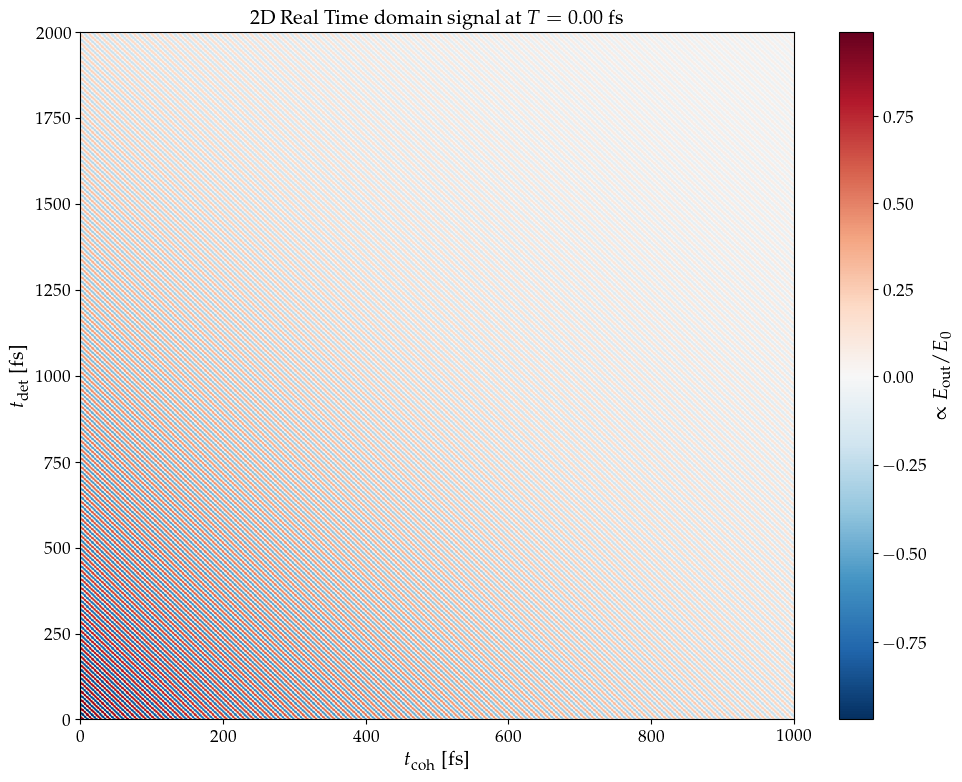

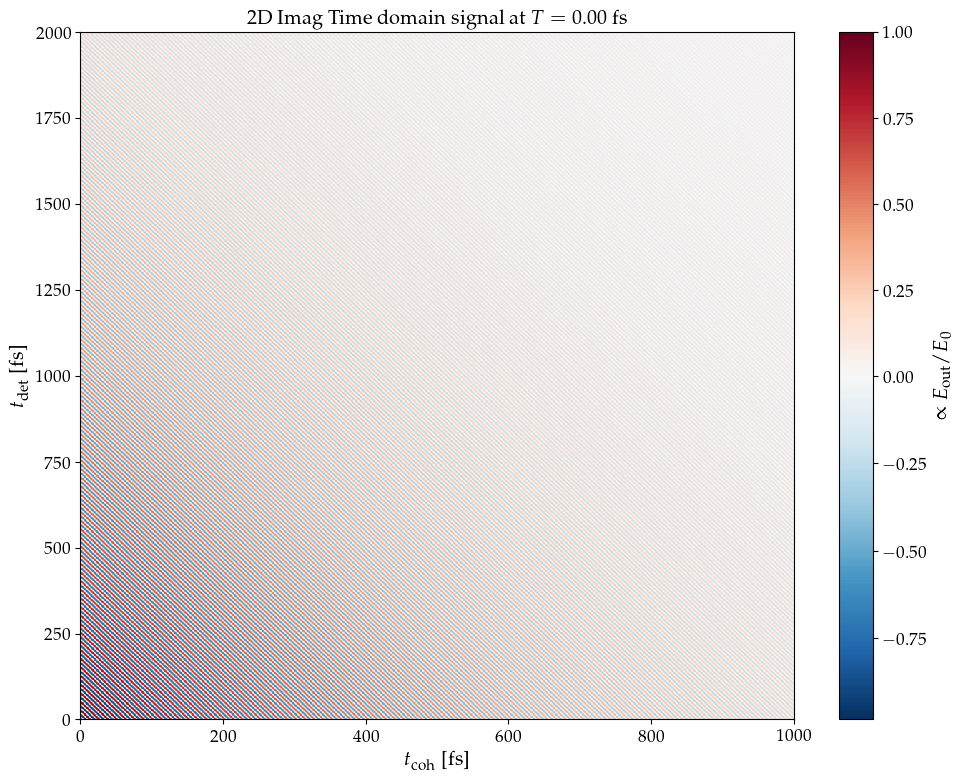

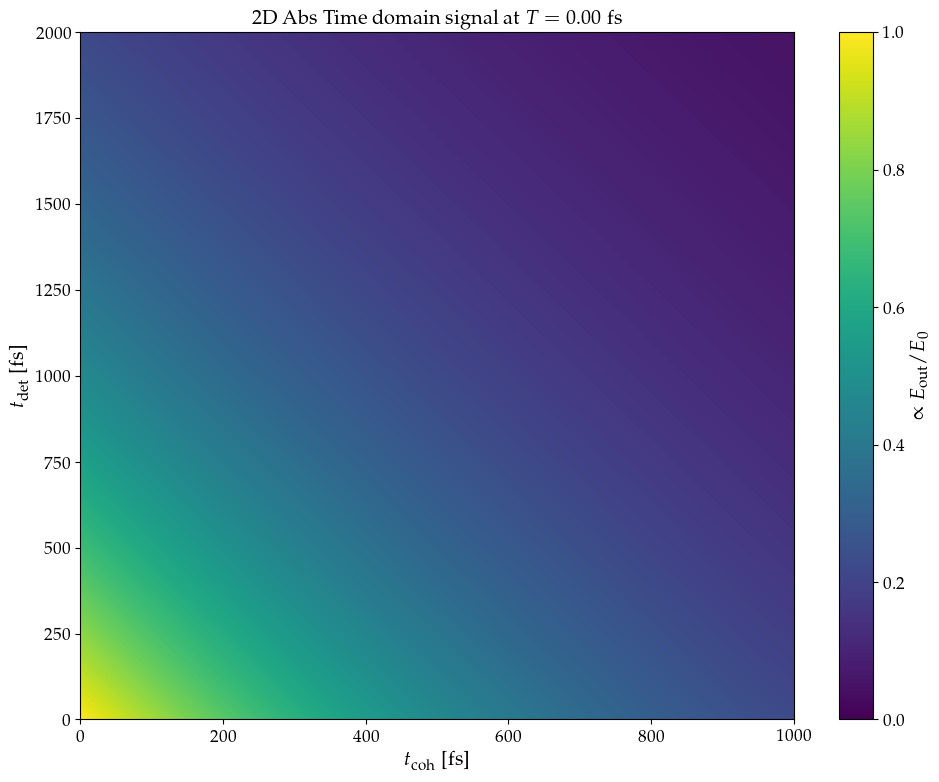

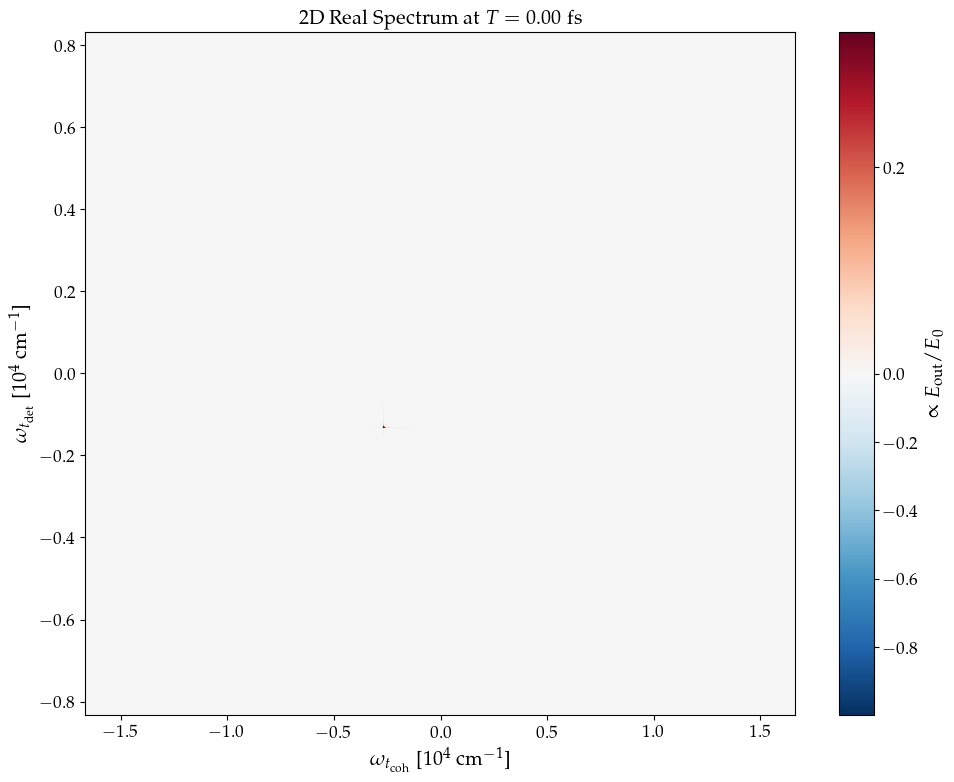

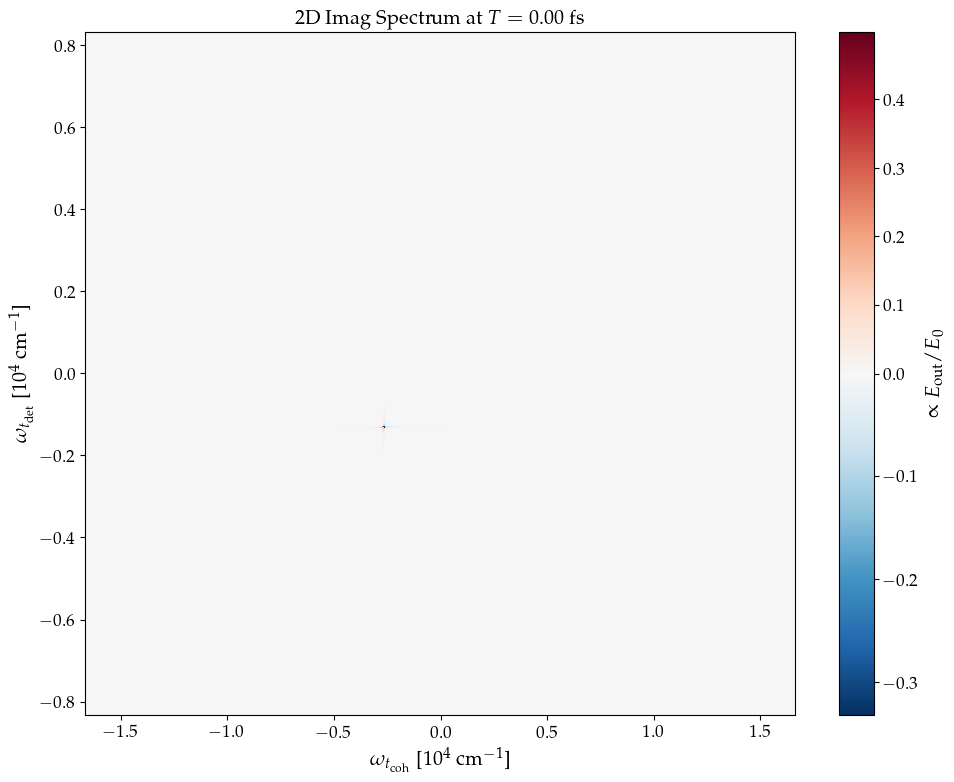

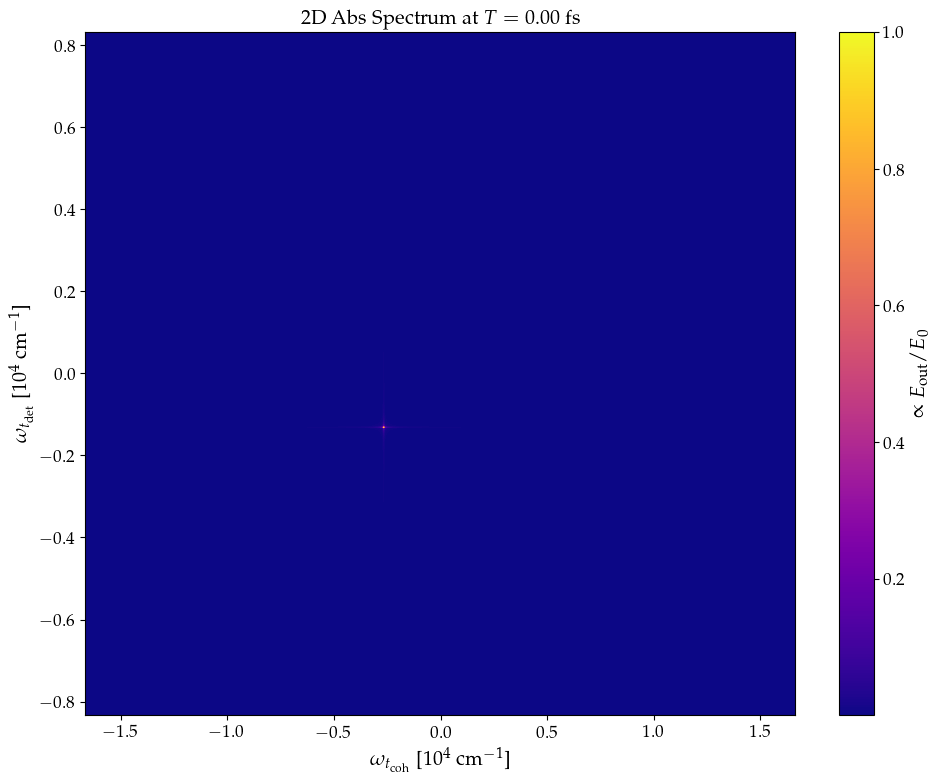

In [23]:
from matplotlib import pyplot as plt
# =============================
# GENERATE TEST DATA FOR 2D PLOTTING AND FFT
# =============================

### Create coordinate arrays
x = np.linspace(0, 1000, 1000)
y = np.linspace(0, 2000, 1000)

data = np.zeros((len(y), len(x)), dtype=complex)

### Add a decaying sine function along the diagonal
for i in range(len(y)):
    for j in range(len(x)):
        # Calculate normalized diagonal position (0 to 1)
        diag_pos_y = i / (len(y) - 1)  # normalized y position
        diag_pos_x = j / (len(x) - 1)  # normalized x position
        
        # Only fill values near the diagonal
        if abs(diag_pos_y - diag_pos_x) < 1:  # within 10% of diagonal
            # Calculate position along diagonal (0 to 1)
            diag_progress = (diag_pos_y + diag_pos_x) / 2
            
            # Create decaying sine wave
            amplitude = np.exp(-3 * diag_progress)  # exponential decay
            frequency = 1000  # oscillation frequency
            phase_shift = 0
            
            # Calculate complex value
            real_part = amplitude * np.sin(frequency * diag_progress + phase_shift)
            imag_part = amplitude * np.cos(frequency * diag_progress + phase_shift)
            
            data[i, j] = real_part + 1j * imag_part


print(f"Data shape: {data.shape}")
print(f"Max absolute value: {np.max(np.abs(data)):.3f}")
print(f"Non-zero elements: {np.count_nonzero(data)}")

# =============================
# PLOT ORIGINAL 2D DATA
# =============================

### Plot different components of the original data
components = ["real", "imag", "abs"]

for component in components:
    fig = plot_2d_el_field(
        axis_det=x,
        axis_coh=y, 
        data=data,
        domain="time",
        component=component,
        t_wait=0.0,
    )
    
# =============================
# COMPUTE AND PLOT FFT
# =============================
### Compute 2D FFT using the wavenumber function
freq_x, freq_y, data_fft = compute_2d_fft_wavenumber(x, y, data)

print(f"\nFFT results:")
print(f"Frequency x shape: {freq_x.shape}")
print(f"Frequency y shape: {freq_y.shape}")
print(f"FFT data shape: {data_fft.shape}")
print(f"FFT max absolute value: {np.max(np.abs(data_fft)):.3f}")

### Plot different components of the FFT data
for component in components:
    fig = plot_2d_el_field(
        axis_det=freq_x,
        axis_coh=freq_y,
        data=data_fft,
        domain="freq",
        component=component,
        t_wait=0.0,
        section=(-4,4,-4,4)
    )

In [3]:
from types import SimpleNamespace
args = SimpleNamespace(t_coh=5, t_wait=0.0, t_det_max=300.0, dt=1.0)

sim_oqs, time_cut = create_base_sim_oqs(args)

# Run single simulation
rel_path = run_single_t_coh_with_sim(
    sim_oqs, args.t_coh, save_info=True, time_cut=time_cut
)

NameError: name 'create_base_sim_oqs' is not defined

In [ ]:
t_coh = sim_oqs.simulation_config.t_coh
t_wait = sim_oqs.simulation_config.t_wait
times = sim_oqs.times_local
fwhms = sim_oqs.laser.pulse_fwhms

full_sequence = sim_oqs.laser
n_pulses = len(full_sequence.pulses)

if n_pulses < 2:
    raise ValueError("Need at least 2 pulses for segmented evolution")

# Initialize variables for loop
current_state = sim_oqs.system.psi_ini
prev_pulse_start_idx = 0

from qspectro2d.spectroscopy.calculations import _ensure_valid_times, _compute_next_start_point, compute_pulse_evolution

# Loop over first n_pulses - 1 segments
for pulse_idx in range(n_pulses - 1):
    # Calculate pulse start index
    if pulse_idx == 0:
        # First pulse: start at t_coh - fwhm
        pulse_start_idx = np.abs(times - (t_coh - fwhms[pulse_idx + 1])).argmin()
        times_segment = _ensure_valid_times(times[: pulse_start_idx + 1], times)
    elif pulse_idx == 1:
        pulse_start_idx = np.abs(times - (t_coh + t_wait - fwhms[pulse_idx + 1])).argmin()
    else:
        raise ValueError("STILL TODO implement general n-pulse evolution")
        
    times_segment = times[prev_pulse_start_idx : pulse_start_idx + 1]
    times_segment = _ensure_valid_times(times_segment, times, prev_pulse_start_idx)
    
    # Update simulation parameters for this segment
    sim_oqs.times_local = times_segment
    sim_oqs.laser = LaserPulseSequence(pulses=full_sequence.pulses[:pulse_idx + 1])
    sim_oqs.system.psi_ini = current_state
    
    # Compute evolution for this segment
    current_state = _compute_next_start_point(sim_oqs=sim_oqs)
    
    # Update for next iteration
    print("pulse start idx:", pulse_start_idx, "prev pulse start idx:", prev_pulse_start_idx)
    prev_pulse_start_idx = pulse_start_idx

# Final segment: evolution with detection (last pulse)
times_final = _ensure_valid_times(times[pulse_start_idx:], times, pulse_start_idx)
sim_oqs.times_local = times_final
print(times_final, sim_oqs.times_det, sim_oqs.times_det_actual)
sim_oqs.laser = full_sequence
sim_oqs.system.psi_ini = current_state

data_final = compute_pulse_evolution(sim_oqs=sim_oqs, store_states=True)
sim_oqs.times_local = times

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(data_final.times, np.abs(complex_polarization(sim_oqs.system.dip_op, data_final.states)), label=f'<mu>')
plt.xlabel(r"Time $t$")
plt.ylabel(r"Population")
plt.title(r"Population Dynamics of a Qubit")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from qspectro2d.spectroscopy.calculations import _ensure_valid_times
n_pulses = len(sim_oqs.laser.pulse_peak_times)
times = sim_oqs.times_local
fwhms = sim_oqs.laser.pulse_fwhms
peak_times = sim_oqs.laser.pulse_peak_times
prev_pulse_start_idx = 0
for pulse_idx in range(1, n_pulses):
    # Calculate pulse start index
    next_pulse_start_time = peak_times[pulse_idx] - fwhms[pulse_idx]
    next_pulse_start_idx = np.abs(times - next_pulse_start_time).argmin()
    times_segment = times[prev_pulse_start_idx : next_pulse_start_idx + 1]
    times_segment = _ensure_valid_times(times_segment, times, prev_pulse_start_idx)
    print(
        f"  Segment {pulse_idx}: {len(times_segment)} points from {times_segment[0]:.2f} to {times_segment[-1]:.2f} fs"
    )
    prev_pulse_start_idx = next_pulse_start_idx


In [ ]:
from qspectro2d.spectroscopy.calculations import _ensure_valid_times, _compute_next_start_point
from copy import deepcopy
copy_sim_oqs = deepcopy(sim_oqs)
t_coh = sim_oqs.simulation_config.t_coh
t_wait = sim_oqs.simulation_config.t_wait
print("t_coh:", t_coh, "t_wait:", t_wait, flush=True)
times = sim_oqs.times_local
print("global times", copy_sim_oqs.times_global)
print("local times", copy_sim_oqs.times_local)
print("times:", times, flush=True)
fwhms = sim_oqs.laser.pulse_fwhms

full_sequence = sim_oqs.laser
n_pulses = len(full_sequence.pulses)

if n_pulses < 2:
    raise ValueError("Need at least 2 pulses for segmented evolution")

# Initialize variables for loop
current_state = sim_oqs.system.psi_ini
prev_pulse_start_idx = 0

# Loop over first n_pulses - 1 segments
for pulse_idx in range(n_pulses - 1):
    # Calculate pulse start index
    if pulse_idx == 0:
        # First pulse: start at t_coh - fwhm
        pulse_start_idx = np.abs(times - (t_coh - fwhms[pulse_idx + 1])).argmin()
        times_segment = _ensure_valid_times(times[: pulse_start_idx + 1], times)
    elif pulse_idx == 1:
        pulse_start_idx = np.abs(
            times - (t_coh + t_wait - fwhms[pulse_idx + 1])
        ).argmin()
    else:
        raise ValueError("STILL TODO implement general n-pulse evolution")

    times_segment = times[prev_pulse_start_idx : pulse_start_idx + 1]
    times_segment = _ensure_valid_times(times_segment, times, prev_pulse_start_idx)
    print(times_segment)

    # Update simulation parameters for this segment
    copy_sim_oqs.times_local = times_segment
    copy_sim_oqs.laser = LaserPulseSequence(
        pulses=full_sequence.pulses[: pulse_idx + 1]
    )
    copy_sim_oqs.system.psi_ini = current_state

    # Compute evolution for this segment
    current_state = _compute_next_start_point(sim_oqs=copy_sim_oqs)

    # Update for next iteration
    prev_pulse_start_idx = pulse_start_idx

# Final segment: evolution with detection (last pulse)
times_final = _ensure_valid_times(
    times[prev_pulse_start_idx:], times, prev_pulse_start_idx
)
print("Final times:", times_final, copy_sim_oqs.times_det_actual, flush=True)
copy_sim_oqs.times_local = times_final


In [ ]:
# =============================
# TEST: detection_times array filling
# =============================
time_cut = 500.1  # Example time cut value
print("sim_oqs.times_det:", sim_oqs.times_det)
print("sim_oqs.times_det_actual:", sim_oqs.times_det_actual)
print("time_cut:", time_cut)

detection_times = sim_oqs.times_det[sim_oqs.times_det_actual < time_cut]
print("Initial detection_times:", detection_times)

# Fill the rest of detection_times with zeros to match the length of sim_oqs.times_det
if len(detection_times) < len(sim_oqs.times_det):
    zeros_to_add = len(sim_oqs.times_det) - len(detection_times)
    detection_times = np.concatenate([detection_times, np.zeros(zeros_to_add)])

print("Filled detection_times:", detection_times)
print("Length of detection_times:", len(detection_times))
print("Length of sim_oqs.times_det:", len(sim_oqs.times_det))

# Check if the arrays are filled correctly
if len(detection_times) == len(sim_oqs.times_det):
    print("✓ detection_times array is correctly filled to match sim_oqs.times_det length.")
else:
    print("❌ detection_times array length does not match sim_oqs.times_det length.")


In [ ]:
t_coh = sim_oqs.simulation_config.t_coh
t_wait = sim_oqs.simulation_config.t_wait
times = sim_oqs.times_local
fwhms = sim_oqs.laser.pulse_fwhms

full_sequence = sim_oqs.laser
n_pulses = len(full_sequence.pulses)

if n_pulses < 2:
    raise ValueError("Need at least 2 pulses for segmented evolution")

# Initialize variables for loop
current_state = sim_oqs.system.psi_ini
prev_pulse_start_idx = 0

from qspectro2d.spectroscopy.calculations import _ensure_valid_times, _compute_next_start_point, compute_pulse_evolution

laser = sim_oqs.laser
peak_times = laser.pulse_peak_times
fwhms = laser.pulse_fwhms
psi_ini = sim_oqs.system.psi_ini
times = sim_oqs.times_local

n_pulses = len(laser.pulses)

print(
    f"  times_local: {len(times)} points from {times[0]:.2f} to {times[-1]:.2f} fs"
)
print(f"  times_det: {len(sim_oqs.times_det)} points")
print(f"  fwhms: {fwhms}")
print(f"  n_pulses: {n_pulses}")

prev_pulse_start_idx = 0  # first -> include the time range before the first pulse
current_state = psi_ini
# Loop over pulses to calculate new start point n_pulses - 1
for pulse_idx in range(1, n_pulses):
    # Calculate pulse start index
    next_pulse_start_time = peak_times[pulse_idx] - fwhms[pulse_idx]
    next_pulse_start_idx = np.abs(times - next_pulse_start_time).argmin()
    times_segment = times[prev_pulse_start_idx : next_pulse_start_idx + 1]
    times_segment = _ensure_valid_times(times_segment, times, prev_pulse_start_idx)
    print(
        f"  Segment {pulse_idx}: {len(times_segment)} points from {times_segment[0]:.2f} to {times_segment[-1]:.2f} fs"
    )

    # Update simulation parameters for this segment
    sim_oqs.times_local = times_segment
    sim_oqs.laser = LaserPulseSequence(pulses=laser.pulses[: pulse_idx + 1])

    # Compute evolution for this segment
    current_state = _compute_next_start_point(sim_oqs=sim_oqs)
    sim_oqs.system.psi_ini = current_state

    # Update for next iteration
    prev_pulse_start_idx = next_pulse_start_idx

times_final = _ensure_valid_times(
    times[prev_pulse_start_idx:], times, prev_pulse_start_idx
)

sim_oqs.times_local = times_final
sim_oqs.laser = laser

data_final = compute_pulse_evolution(sim_oqs=sim_oqs, store_states=True)

detection_length = len(sim_oqs.times_det)

# Ensure we have enough states
if len(data_final.states) < detection_length:
    print(
        f"Not enough states in n pulse evo: got {len(data_final.states)}, need {detection_length}\n"
        f"  Final times: {len(times_final)} points from {times_final[0]:.2f} to {times_final[-1]:.2f} fs"
    )
    # Pad with the last state
    final_states = data_final.states.copy()
    while len(final_states) < detection_length:
        final_states.append(
            final_states[-1] if final_states else sim_oqs.system.psi_ini
        )
else:
    final_states = data_final.states[-detection_length:]
    final_times = data_final.times[-detection_length:]

sim_oqs.reset_times_local()  # restore original times
sim_oqs.system.psi_ini = psi_ini  # restore initial state

# Debug: Check the states being returned
print(f"Total states computed: {len(data_final.states)}")
print(f"Detection length expected: {detection_length}")
print(f"Final states extracted: {len(final_states)}")

sim_oqs.times_local = times  # restore original times

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(final_times, np.abs(complex_polarization(sim_oqs.system.dip_op, final_states)), label=f'<mu>')
plt.xlabel(r"Time $t$")
plt.ylabel(r"Population")
plt.title(r"Population Dynamics of a Qubit")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
times = [0, 1, 2, 3, 4, 5]
times[:2]

In [ ]:
times, datas, sim_oqs = compute_1d_polarization(sim_oqs=sim_oqs, plot_example_evo=True)
rwa_sl = sim_oqs.simulation_config.rwa_sl

plot_example_evo(times, datas, sim_oqs.laser, t_coh, t_wait, rwa_sl=rwa_sl, OED_Solver = sim_oqs.simulation_config.ode_solver, observable_strs=sim_oqs.observable_strs, title="Example Evolution Plot", figsize=(10, 6))

In [ ]:
detection_time = t_coh + t_wait
detection_start_idx = np.abs(data_final.times - detection_time).argmin()
detection_start_idx, detection_time - sim_oqs.times_local[detection_start_idx]

actual_det_times = data_final.times[detection_start_idx:]
actual_det_times

In [ ]:
plot_data = compute_1d_polarization(sim_oqs, time_cut=time_cut, plot_example_polarization = True)
P_full, P_only0, P_only1, P_only2 = plot_data
times = sim_oqs.times_det

pulse_seq = sim_oqs.laser
rwa_sl = sim_oqs.simulation_config.rwa_sl
observable_strs = sim_oqs.observable_strs

plot_example_polarization(times, P_full, P_only0, P_only1, P_only2)

In [ ]:
# =============================
# TEST: extract_ift_signal_component function
# =============================

### Test the IFT signal component extraction function
print("Testing extract_ift_signal_component function...")

# Create test phase array and results matrix
phases = [0, np.pi/2, np.pi, 3*np.pi/2]  # Standard phase cycling
n_phases = len(phases)

# Create test data - simulate phase-cycled results
test_times = np.linspace(0, 50, 100)
dt_test = test_times[1] - test_times[0]

print(f"Test times shape: {test_times.shape}")
print(f"Time step dt: {dt_test:.3f}")
print(f"Number of phases: {n_phases}")

# Generate synthetic phase-cycled data
results_matrix = np.zeros((n_phases, n_phases), dtype=object)

for phi1_idx, phi_1 in enumerate(phases):
    for phi2_idx, phi_2 in enumerate(phases):
        # Create complex signal with phase-dependent amplitude
        base_signal = np.exp(1j * 0.1 * test_times)  # Base oscillation
        phase_modulation = np.exp(1j * (phi_1 + phi_2))  # Phase modulation
        
        # Add some realistic features
        envelope = np.exp(-0.02 * test_times)  # Decay envelope
        noise = 0.05 * (np.random.randn(len(test_times)) + 1j * np.random.randn(len(test_times)))
        
        results_matrix[phi1_idx, phi2_idx] = (base_signal * phase_modulation * envelope + noise)

print(f"Results matrix shape: {results_matrix.shape}")
print(f"Each element shape: {results_matrix[0, 0].shape}")

try:
    # Test different signal components
    test_components = [
        [-1, 1, 0],   # Common component in 2D spectroscopy
        [1, -1, 0],   # Another common component
        [0, 0, 0],    # Zero component (should give average)
        [1, 1, 0],    # Positive component
        [-1, -1, 0],  # Negative component
    ]
    
    for component in test_components:
        print(f"\n--- Testing component {component} ---")
        
        # Extract IFT signal component
        extracted_signal = extract_ift_signal_component(
            results_matrix=results_matrix,
            phases=phases,
            component=component
        )
        
        print(f"Extracted signal shape: {extracted_signal.shape}")
        print(f"Signal type: {type(extracted_signal)}")
        print(f"Signal dtype: {extracted_signal.dtype}")
        print(f"Max amplitude: {np.max(np.abs(extracted_signal)):.4f}")
        print(f"Mean amplitude: {np.mean(np.abs(extracted_signal)):.4f}")
        
        # Check if signal is complex
        if np.iscomplexobj(extracted_signal):
            print(f"Real part range: [{np.min(np.real(extracted_signal)):.4f}, {np.max(np.real(extracted_signal)):.4f}]")
            print(f"Imag part range: [{np.min(np.imag(extracted_signal)):.4f}, {np.max(np.imag(extracted_signal)):.4f}]")
        
        # Verify the extracted signal has the same length as input
        if len(extracted_signal) == len(test_times):
            print("✓ Output length matches input length")
        else:
            print(f"❌ Length mismatch: expected={len(test_times)}, got={len(extracted_signal)}")
    
    print(f"\n{'='*50}")
    print("✅ extract_ift_signal_component function tests completed successfully!")
    
except Exception as e:
    print(f"❌ ERROR testing extract_ift_signal_component: {e}")
    print(f"Error type: {type(e).__name__}")
    import traceback
    traceback.print_exc()

In [ ]:

# Additional test: Test with identical data (should give zero for non-zero components)
print(f"\n--- Testing with identical data (debugging phase cycling issue) ---")
try:
    # Create test matrix where all elements are identical (simulating your issue)
    identical_signal = np.array([1+1j, 2+2j, 3+3j, 4+4j])
    identical_matrix = np.zeros((n_phases, n_phases), dtype=object)
    
    for i in range(n_phases):
        for j in range(n_phases):
            identical_matrix[i, j] = identical_signal.copy()
    
    print("Testing identical data with component [-1, 1, 0]:")
    result_identical = extract_ift_signal_component(
        results_matrix=identical_matrix,
        phases=phases,
        component=[-1, 1, 0]
    )
    
    print(f"Result with identical data: {result_identical}")
    print("This should be close to zero because all phase combinations are identical!")
    
    # Test with component [0, 0, 0] - should give the average
    print("\nTesting identical data with component [0, 0, 0]:")
    result_average = extract_ift_signal_component(
        results_matrix=identical_matrix,
        phases=phases,
        component=[0, 0, 0]
    )
    print(f"Result with [0,0,0] component: {result_average}")
    print("This should equal the original signal (average of identical elements)")
    
except Exception as e:
    print(f"Identical data test failed: {e}")
    import traceback
    traceback.print_exc()
    

print("\n🔍 IFT signal component extraction testing complete!")

In [ ]:
local_sim_oqs = deepcopy(sim_oqs)
test_time = local_sim_oqs.simulation_config.t_coh  # Time when second pulse is active
bphases1 = sim_oqs.laser.pulse_phases
bphases2 = [p.pulse_phase for p in sim_oqs.laser.pulses]
H_a = sim_oqs.H_int_sl(test_time)  # Hamiltonian at t=0
print("BEFORE Laser pulse phases:", bphases1, bphases2)
local_sim_oqs = deepcopy(sim_oqs)

# DEBUG: Check phases before and after update
phi1, phi2, DETECTION_PHASE = 3, 3, 0
local_sim_oqs.laser.update_phases(
    phases=[phi1, phi2, DETECTION_PHASE]
)  # Update the laser phases in the local copy

bphases1 = local_sim_oqs.laser.pulse_phases
bphases2 = [p.pulse_phase for p in local_sim_oqs.laser.pulses]
H_b = local_sim_oqs.H_int_sl(test_time)  # Hamiltonian at t=0
print("AFTER update Laser pulse phases:", bphases1, bphases2)

print("Hamiltonian before vs afterupdate:", H_a, H_b)

## TEST THE Phase Cycling and data generation

In [ ]:
from qspectro2d.spectroscopy.calculations import compute_1d_polarization
local_sim_oqs.laser.update_phases(
    phases=[1,0,0])
data1 = compute_1d_polarization(
    sim_oqs=local_sim_oqs,
)
print(local_sim_oqs.laser.pulse_phases)
print(data1)

local_sim_oqs.laser.update_phases(
    phases=[0,1,0])
data2 = compute_1d_polarization(
    sim_oqs=local_sim_oqs,
)
print(local_sim_oqs.laser.pulse_phases)
print(data2)

local_sim_oqs.laser.update_phases(
    phases=[2,0,0])
data3 = compute_1d_polarization(
    sim_oqs=local_sim_oqs,
)
print(local_sim_oqs.laser.pulse_phases)
print(data3)

print("The difference between data1 and data2 and data3 is:", 
      data2 - data1, data3 - data1, data3 - data2
)

In [ ]:
import numpy as np

# =============================
# DEMO: Averaging over first axis of a 3D array
# =============================

# Create a dummy 3D array: shape (n_freqs, n_phi1, n_phi2)
n_freqs, n_phi1, n_phi2 = 4, 3, 2
dummy_results = np.random.rand(n_freqs, n_phi1, n_phi2)  # random data for demonstration

print("Dummy results shape:", dummy_results.shape)
print("Dummy results array:\n", dummy_results)

# Average over the first axis (frequencies)
results_matrix_avg = np.mean(dummy_results, axis=0)

print("\nAveraged results shape:", results_matrix_avg.shape)
print("Averaged results array:\n", results_matrix_avg)